In [1]:
import pandas as pd ,numpy as np, os, glob, re , matplotlib.pyplot as plt , seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV , StratifiedKFold
from sklearn.metrics import roc_curve, confusion_matrix, classification_report , log_loss
from sklearn.pipeline import Pipeline, FeatureUnion
%precision 2
%matplotlib inline

In [2]:
fpath = glob.glob(os.path.join(os.getcwd(),'smsspam/*'))[0]

In [3]:
with open(fpath) as f:
    print '***************************************************************'
    print f.readline()
    print '***************************************************************'
    lines = [line.strip().split('\t') for  line in f.readlines()]
y, X = [ int(line[0]=='spam')for line in lines] , [line[1] for line in lines]       

***************************************************************
ham	Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...

***************************************************************


In [4]:
text_len = np.array(map(len,X)); text_len.max(), text_len.min(), text_len.mean() , np.bincount(y)

(910, 2, 80.38, array([4826,  747]))

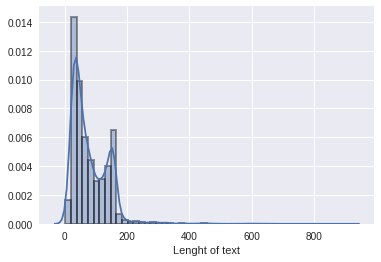

In [5]:
#lt.hist(text_len, 50, normed=1, facecolor='green', alpha=0.75)
ax = sns.distplot(text_len, hist_kws=dict(edgecolor="k", linewidth=2))
plt.xlabel('Lenght of text')
plt.grid(True)
plt.show()

In [6]:
rng = np.random.RandomState(57)
idx = rng.permutation(len(y))
X = np.array(X)[idx]; y = np.array(y)[idx]; text_len = np.array(text_len)[idx]

In [7]:
X1 = np.stack((X,text_len), axis=1)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X1,y, test_size= 0.3, random_state=57, stratify=y)

In [9]:
patten = re.compile('\w+')
vec = CountVectorizer(token_pattern=patten,ngram_range=(1,2),stop_words='english',min_df=2 )

In [10]:
vec.fit(X_train[:,0])

CountVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=None, min_df=2,
        ngram_range=(1, 2), preprocessor=None, stop_words='english',
        strip_accents=None,
        token_pattern=<_sre.SRE_Pattern object at 0x7ff8658b8458>,
        tokenizer=None, vocabulary=None)

In [11]:
X_train_transf = vec.transform(X_train[:,0])
X_test_transf = vec.transform(X_test[:,0])

In [12]:
c_space = np.logspace(-5, 8, 15)
parameters = {'C': c_space}
logreg = LogisticRegression()
cv = StratifiedKFold(n_splits=5)

In [13]:
CV = GridSearchCV(logreg,parameters,cv=cv, n_jobs=1)

In [14]:
CV.fit(X_train_transf, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
       error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': array([  1.00000e-05,   8.48343e-05,   7.19686e-04,   6.10540e-03,
         5.17947e-02,   4.39397e-01,   3.72759e+00,   3.16228e+01,
         2.68270e+02,   2.27585e+03,   1.93070e+04,   1.63789e+05,
         1.38950e+06,   1.17877e+07,   1.00000e+08])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [15]:
y_pred_prob = CV.predict_proba(X_test_transf)[:,1]
pred = CV.predict(X_test_transf)
print'Accuracy: %.4f , log_loss: %.4f' %(CV.score(X_test_transf, y_test) ,log_loss(y_test, pred))

Accuracy: 0.9797 , log_loss: 0.7023


In [16]:
print(confusion_matrix(y_test,pred))
print(classification_report(y_test,pred))

[[1448    0]
 [  34  190]]
             precision    recall  f1-score   support

          0       0.98      1.00      0.99      1448
          1       1.00      0.85      0.92       224

avg / total       0.98      0.98      0.98      1672



In [17]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

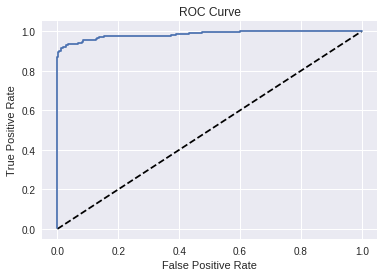

In [18]:
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()